# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4943C9EB8>,
      dtype=object)

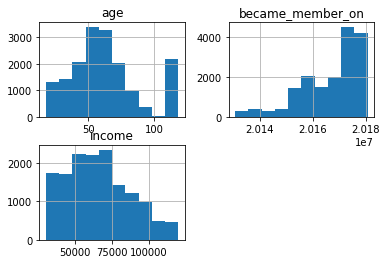

In [16]:
profile.hist()

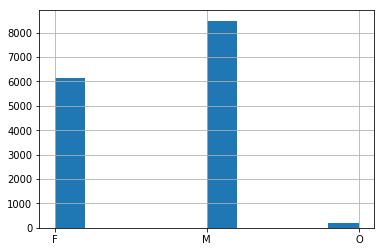

In [4]:
profile['gender'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B494555D68>]],
      dtype=object)

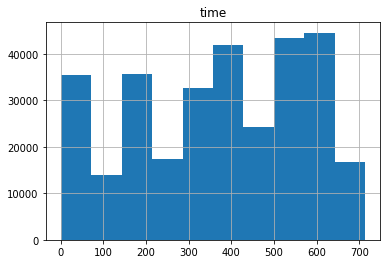

In [18]:
transcript.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4943298D0>,
      dtype=object)

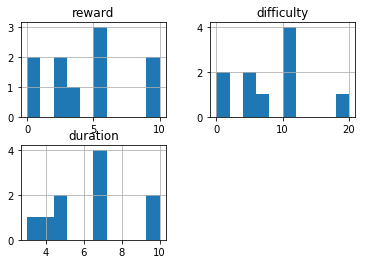

In [15]:
portfolio.hist()

In [2]:
transc_pers = transcript.merge(profile, left_on = 'person', right_on = 'id')

In [15]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
tp_clean = transc_pers[~(transc_pers['age'] == 118)].reset_index(drop = True)

In [17]:
value_df = pd.DataFrame(list(tp_clean['value']))
value_df

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,NaN,19.89,NaN,NaN
3,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
4,NaN,17.78,NaN,NaN
...,...,...,...,...
272757,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
272758,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
272759,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
272760,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [5]:
def new_offer_id(col1, col2):
    new_col = []
    for i in range(len(col1)):
        if isinstance(col1[i], str):
            new_col.append(col1[i])
            if isinstance(col2[i], str):
                print('doubleval')
        elif isinstance(col2[i], str):
            new_col.append(col2[i])
            if isinstance(col1[i], str):
                print('doubleval')
        else:
            new_col.append(col1[i])
    if len(new_col) == len(col1):
        return(new_col)
    else:
        print('fail')

In [18]:
offer_ids = new_offer_id(value_df['offer id'], value_df['offer_id']) 

In [19]:
value_df = value_df.drop(['offer id', 'offer_id', 'reward'], axis = 1)
value_df['offer_id'] = offer_ids

In [20]:
value_df = value_df.merge(portfolio, left_on = 'offer_id', right_on = 'id', how = 'left')

value_df

,amount,offer_id,reward,channels,difficulty,duration,offer_type,id
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
272757,NaN,3f207df678b143eea3cee63160fa8bed,0.0,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed
272758,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
272759,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
272760,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [21]:

df = pd.concat([tp_clean, value_df], axis = 1)
df = df.drop(['value'], axis = 1)

In [22]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def mapper(col):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in df[col]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        encoded.append(coded_dict[val])
    return encoded


    

person_encoded = mapper('person')
del df['person']
del df['id']
df['user_id'] = person_encoded

#nas were set to 2
offer_encoded = mapper('offer_id')
del df['offer_id']
df['offer_id'] = offer_encoded

# show header
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,2
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,2


In [23]:
df['offer_id'] = df['offer_id'].replace(2, ('nan'))
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,nan
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,nan


In [11]:
df.sort_values(['user_id', 'time'], axis = 0).reset_index(drop = True)

,event,time,gender,age,became_member_on,income,amount,reward,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,NaN,1,1
1,offer viewed,6,F,75,20170509,100000.0,NaN,NaN,1,1
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,1,nan
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,1,1
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,1,nan
...,...,...,...,...,...,...,...,...,...,...
272757,offer viewed,504,M,47,20171013,94000.0,NaN,NaN,14824,7
272758,offer received,576,M,47,20171013,94000.0,NaN,NaN,14824,11
272759,offer viewed,576,M,47,20171013,94000.0,NaN,NaN,14824,11
272760,offer received,576,F,58,20161020,78000.0,NaN,NaN,14825,11


In [31]:

#thanks Udacity course
def create_dummy_df(df, cat_cols, dum_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    new_df = df.copy()
    for col in  cat_cols:
        try:
            dums =  pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dum_na)
            new_df = pd.concat([new_df.drop(col, axis=1),dums], axis=1)
        except:
            continue
    return new_df

def list_to_cols(series):
    '''
    INPUT:
    series consisting of a list 
    
    OUTPUT:
    dataframe where items in the list are columns
    '''
    column_names = []
    for i in series:
        if isinstance(i, float) == False:
            for n in i:
                if n not in column_names:
                    column_names.append(n)
    df = pd.DataFrame(columns = column_names)
    series = series.fillna('mk162rl8619')
    for z in column_names:
        df[z] = [1 if z in x else 0 for x in series]
    return(df)


In [42]:
channels_df = list_to_cols(df['channels'])
df = df.drop(['channels'],axis = 1)

In [33]:
channels_df

,web,email,mobile,social
0,1,1,1,0
1,1,1,1,0
2,0,0,0,0
3,1,1,1,0
4,0,0,0,0
...,...,...,...,...
272757,1,1,1,0
272758,1,1,1,1
272759,1,1,1,1
272760,1,1,1,1


In [43]:
for_cats_df = df.select_dtypes(include=['object'])
for_cats_df = for_cats_df.drop(['offer_id'], axis = 1)

cats_df = create_dummy_df(df, for_cats_df.columns, False)

In [44]:
new_df = pd.concat([cats_df, channels_df], axis = 1)
new_df

,time,age,became_member_on,income,amount,reward,difficulty,duration,user_id,offer_id,...,event_offer viewed,event_transaction,gender_M,gender_O,offer_type_discount,offer_type_informational,web,email,mobile,social
0,0,75,20170509,100000.0,NaN,5.0,5.0,7.0,1,1,...,0,0,0,0,0,0,1,1,1,0
1,6,75,20170509,100000.0,NaN,5.0,5.0,7.0,1,1,...,1,0,0,0,0,0,1,1,1,0
2,132,75,20170509,100000.0,19.89,NaN,NaN,NaN,1,nan,...,0,1,0,0,0,0,0,0,0,0
3,132,75,20170509,100000.0,NaN,5.0,5.0,7.0,1,1,...,0,0,0,0,0,0,1,1,1,0
4,144,75,20170509,100000.0,17.78,NaN,NaN,NaN,1,nan,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,504,47,20171013,94000.0,NaN,0.0,0.0,4.0,14824,7,...,1,0,1,0,0,1,1,1,1,0
272758,576,47,20171013,94000.0,NaN,10.0,10.0,5.0,14824,11,...,0,0,1,0,0,0,1,1,1,1
272759,576,47,20171013,94000.0,NaN,10.0,10.0,5.0,14824,11,...,1,0,1,0,0,0,1,1,1,1
272760,576,58,20161020,78000.0,NaN,10.0,10.0,5.0,14825,11,...,0,0,0,0,0,0,1,1,1,1


In [26]:
df_gb = df.groupby(['user_id', 'time'])

KeyError: False

In [33]:
df_gb.get_group((1, 0))

,event,time,gender,age,id,became_member_on,income,offer id,amount,offer_id,reward,user_id
0,offer received,0,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,1
